# Info and Results

In this notebook I implement Image Classification with OpenCV using Bag of Words algorithm (BoW) and Support Vector Machine classifeier.

**The process is as follow:**

1.   Train a Vocabulary
  - For a subsample of training data, detect keypoints with DoG (Difference of Gaussians) and calculate descriptors with (SIFT)
  - Train a vocabulary with BoW K-means with a certain amount of 'words' and assign the created vocabulary to a BoW descriptor

2.   Compose a Training Set of BoW descriptors
  - for another training set detect the SIFT keypoints and extract the BoW features (descriptors)

3. Train a SVM


**The Data:**
* Training data 500 no-car images and 500 car images. All with size: 100x400
* Test data:
  - A: One set: similar images as the train data but a with differnt size, thogh small eighter
  - B: Another set with different images (size, colors, different objects)


**Results comparing different number of training samples:**
* For the test set A: 6 out of 13 test images have been misclassified (with 10 training samples for the BoW and 200  for the SVM)
* Increasing the number of samples to train the BoW descriptors worsen the result
* Increasing the number of training data for the SVM made the classifier to predict all but 1 test samples as negative






In [0]:
# !pip uninstall opencv-python -y
# # downgrade OpenCV a bit since some none-free features are not avilable
# !pip install opencv-contrib-python==3.4.2.17 --force-reinstall

In [0]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

In [3]:
cd /content/drive/My Drive/Colab Notebooks/OpenCV

/content/drive/My Drive/Colab Notebooks/OpenCV


In [0]:
# Define training sample number:
BOW_NUM_TRAINING_SAMPLES_PER_CLASS = 10 
# Increased from 10 to 40 returned a worse classification result
SVM_NUM_TRAINING_SAMPLES_PER_CLASS = 500
# Increasing the training examples from 100 to 500 put all tests into 
# not-car class

In [0]:
# Create SIFT (creating descriptors) object 
# and FLANN (matching descriptors) object
# BOWKmeansTrainer (training BoW vocabulary)
# BOWImgDescriptorExtractor (convert descriptors into BoW descriptors)
sift = cv2.xfeatures2d.SIFT_create()

FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = {}
flann = cv2.FlannBasedMatcher(index_params, search_params)

bow_kmeans_trainer = cv2.BOWKMeansTrainer(40) # par: number of clusters
bow_extractor = cv2.BOWImgDescriptorExtractor(sift, flann)

In [0]:
# Get paths of an image:
def get_pos_and_neg_paths(i):
    pos_path = 'CarData/TrainImages/pos-%d.png' % (i+1)
    neg_path = 'CarData/TrainImages/neg-%d.png' % (i+1)
    return pos_path, neg_path
	
# Load the image, extract SIFR descriptors and add them to the BoW trainer
def add_sample(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    keypoints, descriptors = sift.detectAndCompute(img, None)
    if descriptors is not None:
        bow_kmeans_trainer.add(descriptors)

In [0]:
# Assemble a training set
for i in range(BOW_NUM_TRAINING_SAMPLES_PER_CLASS):
    pos_path, neg_path = get_pos_and_neg_paths(i)
    add_sample(pos_path)
    add_sample(neg_path)

In [8]:
len(bow_kmeans_trainer.getDescriptors())

20

In [0]:
# k-mean classification(clutering) of the descriptors to get the vocabulary
'''we train the vocabulary with samples of SIFT descriptors ?!?!'''
voc = bow_kmeans_trainer.cluster()
# Assign the vocabulary to the BoW descriptor extractor
bow_extractor.setVocabulary(voc)

In [10]:
# Number of visual words - these are all arrays
len(voc)

40

In [11]:
print(bow_extractor.descriptorSize())
print(bow_extractor.descriptorType())
len(bow_extractor.getVocabulary()) # This is the vocabulary we assigned previously

40
5


40

In [0]:
# For an image: 
# Get the DoG features with SIFT
# compute the BoW descriptor vector
def extract_bow_descriptors(img):
    features = sift.detect(img)
    return bow_extractor.compute(img, features)

In [0]:
# Create a dataset containing BoW descritors for all images
# These will be used as features for each image to input into 
# a classifier - here a SVM

'''Note: This is the first place where we separate 
the examples into classes'''

training_data = []
training_labels = []
for i in range(SVM_NUM_TRAINING_SAMPLES_PER_CLASS):
    pos_path, neg_path = get_pos_and_neg_paths(i)

    pos_img = cv2.imread(pos_path, cv2.IMREAD_GRAYSCALE)
    pos_descriptors = extract_bow_descriptors(pos_img)
    # the computed array has a shape (1, 40) as the number of words
    # and as the number of clusters assigned to the K-means trainer
    if pos_descriptors is not None:
        training_data.extend(pos_descriptors)
        training_labels.append(1)

    neg_img = cv2.imread(neg_path, cv2.IMREAD_GRAYSCALE)
    neg_descriptors = extract_bow_descriptors(neg_img)
    if neg_descriptors is not None:
        training_data.extend(neg_descriptors)
        training_labels.append(-1)

In [14]:
print(len(training_data))
training_data[0].shape

998


(40,)

In [15]:
# Create and train an SVM
svm = cv2.ml.SVM_create()
svm.train(np.array(training_data), cv2.ml.ROW_SAMPLE,
          np.array(training_labels))

True

# Testing

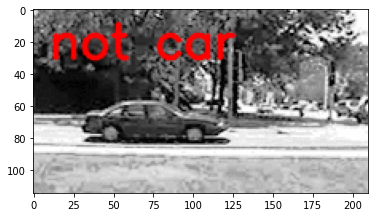

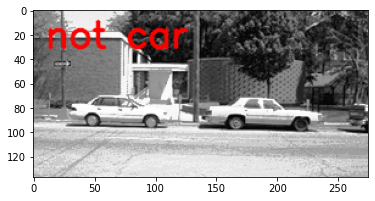

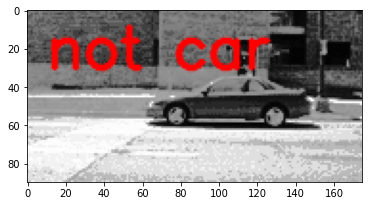

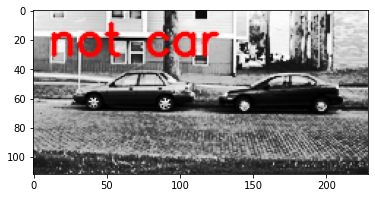

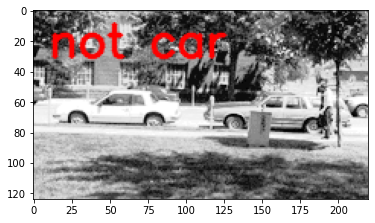

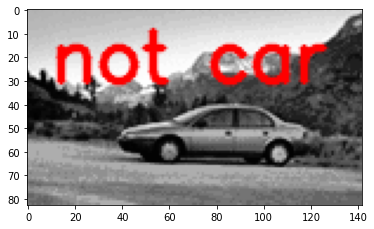

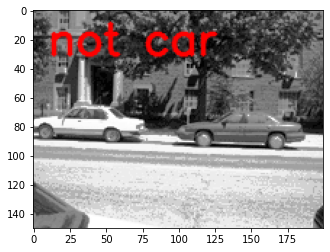

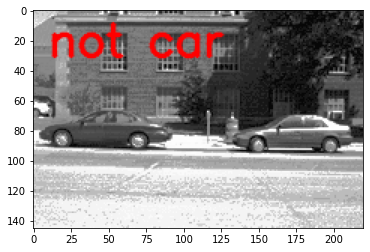

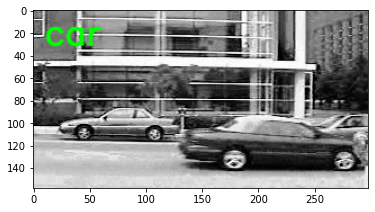

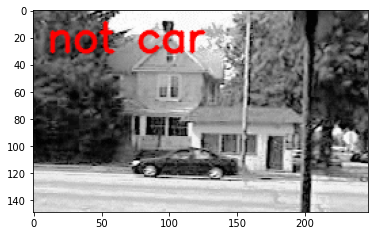

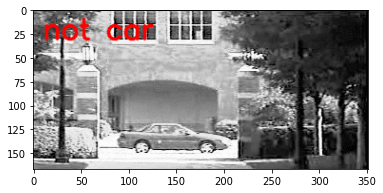

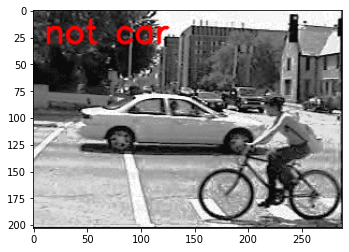

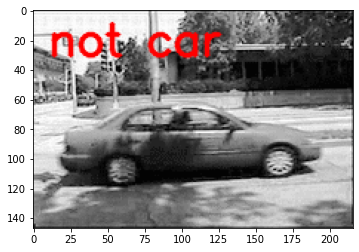

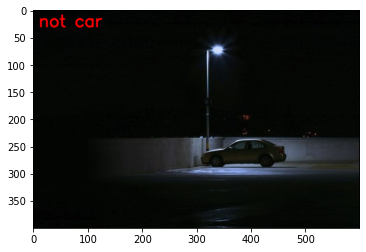

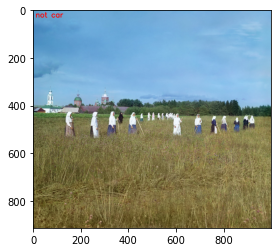

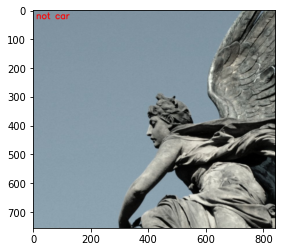

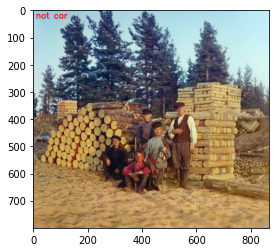

In [16]:
for i, test_img_path in enumerate(['CarData/TestImages/test-0.png',
                      'CarData/TestImages/test-1.png',
                      'CarData/TestImages/test-2.png',
                      'CarData/TestImages/test-3.png',
                      'CarData/TestImages/test-4.png',
                      'CarData/TestImages/test-5.png',
                      'CarData/TestImages/test-6.png',
                      'CarData/TestImages/test-7.png',
                      'CarData/TestImages/Scale/test-93.png',
                      'CarData/TestImages/Scale/test-58.png',
                      'CarData/TestImages/Scale/test-68.png',
                      'CarData/TestImages/Scale/test-16.png',
                      'CarData/TestImages/Scale/test-25.png',
                      'Images/car.jpg',
                      'Images/haying.jpg',
                      'Images/statue.jpg',
                      'Images/woodcutters.jpg']):
    img = cv2.imread(test_img_path)
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    descriptors = extract_bow_descriptors(gray_img)
    prediction = svm.predict(descriptors)

    if prediction[1][0][0] == 1.0:
        text = 'car'
        color = (0, 255, 0)
    else:
        text = 'not car'
        color = (0, 0, 255)
    cv2.putText(img, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1,
                color, 2, cv2.LINE_AA)
    
    # plt.subplot(2,3, i+1)
    plt.imshow(img[:,:,::-1])
    plt.show()
# plt.show()

In [0]:
svm.save('my_svm_500.xml')